# **oceanliner**: observing system simulation experiments (OSSEs) for SWOT in situ campaigns

This notebook enables a user to select a region from one of the 15 [Adopt-a-Crossover](https://www.swot-adac.org/) sites and specify a sampling pattern (e.g., the path of an ocean glider, ship-based underway CTD, Wave Glider, Saildrone, or mooring), and then does the following:
* download llc4320 data to the local machine
* compute steric height and potential vorticity 
* interpolate model fields in space/time over the trajectory
* return set of subsampled variables on a regular grid 
* store and plot outputs, including "true" and "subsampled" steric height 

### User inputs:
* **RegionName**: name of region (corresponding to filename) - options are WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST MarmaraSea  LabradorSea  CapeBasin Boknis GotlandBasin NWAustralia WestAtlantic Yongala - [link to PO.DAAC data listings](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=)
* **start_date**, **ndays**: specify date range as start date & number of days.
* **PLATFORM** : simulated platform with with to sample the model: glider track (`glider`), shipboard underway CTD (`uctd`), Wave Glider (`wave_glider`), Saildrone (`saildrone`) mooring (`mooring`), or a user-specified trajectory (`trajectory_file`), in which casea netCDF file **trajectory_file** must also be specified. Specifying a sampling platform applies realistic default values for platform speed and depth range
* **PATTERN**: survey PATTERN -- can be `lawnmower` or `back-forth`
* **datadir** : directory where data files are stored



### Future developments to include:
* implement other sampling platforms that interact with model current fields (e.g., drifters)
* adapt for the AWS cloud
* compute other variables of interest
* import simulated SWOT data at the same location
* pipe output into optimal interpolation software
* implement other models (including biogeochemical model)
* efficiency improvements






In [1]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import time
import sys
import os
import warnings

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Other third-party packages
import netCDF4 as nc4

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid
import xgcm.grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.dates as mdates

# osse tools package
# del sys.modules['oceanliner_functions']  # uncomment if troubleshooting oceanliner_functions
from oceanliner_functions import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp, rotate_vector_to_EN


In [8]:
# --------------------------------------------------------------------
# USER INPUTS: 
# --------------------------------------------------------------------
# *** users should only have to modify the variables in this cell ***
# --------------------------------------------------------------------


# ------------ region and time span

# RegionName: region with MITgcm llc4320 data on the PO.DAAC 
#   options are:
#     WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
#     MarmaraSea  LabradorSea  CapeBasin Boknis GotlandBasin NWAustralia WestAtlantic Yongala
RegionName = 'WesternMed'
#RegionName = 'ACC_SMST'


# start_date:  first date to subsample the model. 
#   MITgcm llc4320 data are from 2011-Sep-13 to 2012-Nov-15
start_date = datetime.date(2012,1,1)
# ndays: number of days over which to subsample the model (starting at start_date) 
#   note: ndays must be >1 
#   note: a large number of ndays may crash smaller machines
ndays = 10 
# --------------------------------------------------------------------


# ------------ directories -------------------------------------------

# directory where data files are stored
#datadir = '/data3/llc4320/' + RegionName + '/'                     
# directory where generated output files will be stored
#outputdir = '/data3/adac/osse_output/' + RegionName + '/'           
# directory where figures will be stored
#figdir = '/data2/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures

# directory where data files are stored
#datadir = '/data3/llc4320/' + RegionName + '/'                     
# directory where generated output files will be stored
#outputdir = '/data3/adac/osse_output/' + RegionName + '/'           
# directory where figures will be stored
#figdir = '/data2/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures

#ocean computer
#datadir = '/mnt/data/ACC_SMST/osse_model_input/30days/90days'  # input model data are here
#outputdir = '/mnt/data/ACC_SMST/osse_output'   # interpolated data stored here
#figdir = '/mnt/data/ACC_SMST/figures' # store figures#datadir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_model
# --------------------------------------------------------------------
# # directory where data files are stored
# datadir = '/Users/kdrushka/data/adac/mitgcm/netcdf/' + RegionName + '/'                     
# # directory where generated output files will be stored
# outputdir = '/data3/adac/osse_output/' + RegionName + '/'           
# # directory where figures will be stored
# figdir = '/data2/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures


#ocean computer
datadir = '/home/manjaree/Documents/oceanliner_data/osse_model_input/'  # input model data are here
outputdir = '/home/manjaree/Documents/oceanliner_data/osse_output/'   # interpolated data stored here
figdir = '/home/manjaree/Documents/figures/' # store figures#datadir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_





# ------------ sampling parameters ------------------------------------

# PLATFORM: which instrument to sample with:
#   options are glider, uctd, mooring, wave_glider, saildrone, waypoints, or trajectory_file
PLATFORM = 'glider' 
# -----  if *only* PLATFORM is specified, reasonable defaults will be selected for the following parameters:

# WAYPOINTS:
#  specify either a list of lon,lat waypoints as {'x':[151, 153], 'y':[-55, -56]}
#    note: for a mooring, specify a single value for x and y
#    note: xwaypoints & ywaypoints must have the same size
#  or, a filename (string) of a netCDF file specifying the waypoints as {'waypoint_file':'filename.nc'} (EXAMPLE NEEDED)
#  or, None - in which case a simple pattern within the domain will be selected based on "PATTERN" (useful for testing/demo)
#  ** note, if the waypoints are outside of the domain, get_survey_track will raise an error (TODO: add warning earlier)
WAYPOINTS = None #{'x':[2, 2, 2.5, 2.5, 2, 2], 'y':[38, 39, 39, 38, 38, 39]}

# PATTERN: if WAYPOINTS=None, generate waypoints using this pattern:
#   options are back-forth (repeated back+forth betwen two waypoints) or lawnmower (radiator survey)
#   if waypoints are set, the value of PATTERN is irrelevant 
PATTERN = 'lawnmower' # back-forth or lawnmower 

# AT_END: what to do after the end of the list of waypoints is reached.
#   options are reverse (follow the track back to the start), repeat (go straight back to start and then repeat) or terminate (stop) 
AT_END = 'reverse'

# zrange: depth range of measurements as a 2-element list. 
#   * note, if depth values are negative (As in MITgcm), zrange should be negative
zrange = [-1, -500]

# z_res: vertical sampling resolution in m
z_res = 5

# zmooring: for PLATFORM=mooring, 
#   specify the depth of the instruments
#   (default x/y is the center of the domain)
zmooring = [-1, -10, -50, -500, -1000]
      
# hspeed: horizontal speed of the platform (in m/s) 
hspeed = 0.25

# vspeed: vertical speed of the platform through the water (in m/s)
#   for glider, this is the speed at which the glider dives
#   for uctd, this is the fall-rate of the instrument
#   for mooring, wave_glider and saildrone vspeed is irrelevant
vspeed = 0.1


# DERIVED_VARIABLES: whether or not to compute the "derived variables" - 'steric_height' and/or 'vorticity'
#  it takes significant memory and time to derive and save the stored variables, so None is recommended unless these
#  variables are needed
DERIVED_VARIABLES = None # {'steric_height', 'vorticity'} # or, None

# --------------------------------------------------------------------




# ------------ save flags ------- ------------------------------------

# SAVE_FIGURES: if True, save some basic figures
SAVE_FIGURES = False 

# SAVE_PRELIMINARY: if True, save preliminary along-track data. 
#  This takes more space but is faster and less prone to crashing than the gridding step
SAVE_PRELIMINARY = False 


In [9]:
#pwd

In [10]:
#cd ~/Documents/oceanliner_data/osse_model_inputdata

In [11]:
#os.listdir('/home/manjaree/Documents/oceanliner_data/osse_model_input')

In [12]:
# store the user-specified details in "sampling_details" variable
sampling_details = {
   'PLATFORM' : PLATFORM,
    'WAYPOINTS' : WAYPOINTS,
    'PATTERN' : PATTERN,
    'zrange' : zrange,  
    'z_res' : z_res,
    'hspeed' : hspeed,
    'vspeed' : vspeed,
    'AT_END' : AT_END,
    'zmooring' : zmooring,
    'DERIVED_VARIABLES' : DERIVED_VARIABLES,
    'SAVE_PRELIMINARY' : SAVE_PRELIMINARY,
    'start_date' : start_date,
    'ndays' : ndays
}


#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. 

In [13]:
# download files:
#download_llc4320_data(RegionName, datadir, start_date, ndays)

# derive & save new files with steric height & vorticity
if sampling_details['DERIVED_VARIABLES']:
    compute_derived_fields(RegionName, datadir, start_date, ndays, sampling_details['DERIVED_VARIABLES'])

In [14]:
#datadir

In [15]:
#os.listdir('/mnt/data/ACC_SMST/osse_model_input/30days/90days/')

#### Load all model data files. 


In [16]:
%%time
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]

#ocean computer
#datadir = '/mnt/data/ACC_SMST/osse_model_input/30days/90days'  # input model data are here
#outputdir = '/mnt/data/ACC_SMST/osse_output'   # interpolated data stored here
#figdir = '/mnt/data/ACC_SMST/figures' # store figures#datadir = '/home/manjaree/Documents/LLC4320_pre-SWOT_10_days/ACC_SMST/osse_model_input/'  # input model data are here
#target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
#target_files = [f'{datadir}/LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files

target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)]

# open the dataset
ds = xr.open_mfdataset(target_files)

# XC, YC and Z are the same at all times, so select a single time
# (note, this breaks for a single file - always load >1 file)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

CPU times: user 565 ms, sys: 24.3 ms, total: 590 ms
Wall time: 622 ms


### Transform vector quantities to the tracer grid and rotate if needed

Interpolate velocities (ocean currents and wind) to the tracer grid for consistency with tracers.

At higher latitudes, vector quantities (U/V/TAU_U/TAU_V) are in model coordinates and must be rotated to earth coordinates
rotation vectors are given in AngleSN, AngleCS

In [17]:
# first, interpolate U,V and oceTAUX, oceTAUY to the tracer grid
print('interpolating to tracer grid')

# xgcm.Grid interp raises a DeprecationWarning
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


# define grid
grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                     'Y':{'center': 'j', 'left': 'j_g'},
                     'T':{'center': 'time'},
                     'Z':{'center': 'k'}})    
U_c = grid.interp(ds.U, 'X', boundary='extend')
V_c = grid.interp(ds.V, 'Y', boundary='extend')
# do the same for TAUX and TAUY:
oceTAUX_c = grid.interp(ds.oceTAUX, 'X', boundary='extend')
oceTAUY_c = grid.interp(ds.oceTAUY, 'Y', boundary='extend')


# second, rotate vectors to geophysical (east, north) coordinates instead of model ones 
# (if needed, i.e. if AngleSN exists)
angles = "AngleSN"
if 'AngleSN' in list(ds.data_vars):
    print('Rotating vector quantities to east/north')
    U_c, V_c = rotate_vector_to_EN(U_c, V_c, ds['AngleCS'], ds['AngleSN'])
    oceTAUX_c, oceTAUY_c = rotate_vector_to_EN(oceTAUX_c, oceTAUY_c, ds['AngleCS'], ds['AngleSN'])

# replace the vector variables in ds 
print('replacing vectors with tracer-grid versions')
ds['U'] = U_c
ds['V'] = V_c
ds['oceTAUX'] = oceTAUX_c
ds['oceTAUY'] = oceTAUY_c

interpolating to tracer grid
replacing vectors with tracer-grid versions


In [18]:
%%time
# load the corresponding derived fields 
if sampling_details['DERIVED_VARIABLES']:
    derivedir = datadir + 'derived/'
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    dsd = xr.open_mfdataset(derived_files)
    
    # merge the derived and raw data
    ds = ds.merge(dsd)
    
# drop a bunch of other vars we don't actually use - can comment this out if these are wanted
ds = ds.drop_vars({'DXV','DYU', 'DXC','DXG', 'DYC','DYG', 'XC_bnds', 'YC_bnds', 'Zp1', 'Zu','Zl','Z_bnds', 'nb'})
ds

CPU times: user 161 µs, sys: 0 ns, total: 161 µs
Wall time: 165 µs


<xarray.Dataset>
Dimensions:   (j_g: 265, i: 192, i_g: 192, j: 265, k: 76, k_u: 76, k_l: 76,
               k_p1: 77, time: 240)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 261.0 262.0 263.0 264.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 260.0 261.0 262.0 263.0 264.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 66 67 68 69 70 71 72 73 74 75
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 66 67 68 69 70 71 72 73 74 75
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 66 67 68 69 70 71 72 73 74 75
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 67 68 69 70 71 72 73 74 75 76
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-10T23:00:00
Data variables: (12/21)
    XC        (time, j, i) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    YC        (time, j, i) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    Depth     (time, j, i) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    XG        (time, j_g, i_g) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    YG        (time, j_g, i_g) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    RAZ       (time, j_g, i_g) float32 dask.array<chunksize=(24, 265, 192), meta=np.ndarray>
    ...        ...
    oceTAUY   (time, j, i) float64 dask.array<chunksize=(24, 264, 192), meta=np.ndarray>
    Theta     (time, k, j, i) float64 dask.array<chunksize=(24, 76, 265, 192), meta=np.ndarray>
    Salt      (time, k, j, i) float64 dask.array<chunksize=(24, 76, 265, 192), meta=np.ndarray>
    U         (time, k, j, i) float32 dask.array<chunksize=(24, 76, 265, 191), meta=np.ndarray>
    V         (time, k, j, i) float64 dask.array<chunksize=(24, 76, 264, 192), meta=np.ndarray>
    W         (time, k_l, j, i) float64 dask.array<chunksize=(24, 76, 265, 192), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional MEDITERRANEAN SEA
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

### Create & plot sampling track

Use the `get_survey_track` function to apply the sampling strategy specified in `sampling_details`

returns:
* `survey_track`: lat/lon/time/depth of the platform's track,
* `survey_indices`: indices of the survey track in "ds"
* `sampling_details`: the actual sampling details used, ie, those that were specified + any default values


In [19]:
del sys.modules['oceanliner_functions']  # uncomment if troubleshooting oceanliner_functions
from oceanliner_functions import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

survey_track, survey_indices, sampling_details = get_survey_track(ds, sampling_details)

# print:
sampling_details

no waypoints specified - using defaults
originally,  17208  points
limited to  17200 points: n_profiles= 86.0 ,  100 depths per profile,  200 depths per two-way


{'zrange': [-1, -500.0],
 'z_res': 5,
 'hspeed': 0.25,
 'vspeed': 0.1,
 'AT_END': 'reverse',
 'PATTERN': 'lawnmower',
 'SAVE_PRELIMINARY': False,
 'PLATFORM': 'glider',
 'WAYPOINTS': None,
 'zmooring': [-1, -10, -50, -500, -1000],
 'DERIVED_VARIABLES': None,
 'start_date': datetime.date(2012, 1, 1),
 'ndays': 10,
 'distance_total_km': 214.9875,
 'time_total_s': 859950.0}

In [20]:
# ---- generate name of file to save outputs in ---- 
filename_base = (f'OSSE_{RegionName}_{sampling_details["PLATFORM"]}_{start_date}_to_{start_date + datetime.timedelta(ndays)}_maxdepth{int(sampling_details["zrange"][1])}')
filename_out_base = (f'{outputdir}{filename_base}')
print(filename_base)
sampling_details['filename_out_base'] = filename_out_base

OSSE_WesternMed_glider_2012-01-01_to_2012-01-11_maxdepth-500


### Visualize the sampling track over a single model snapshot:

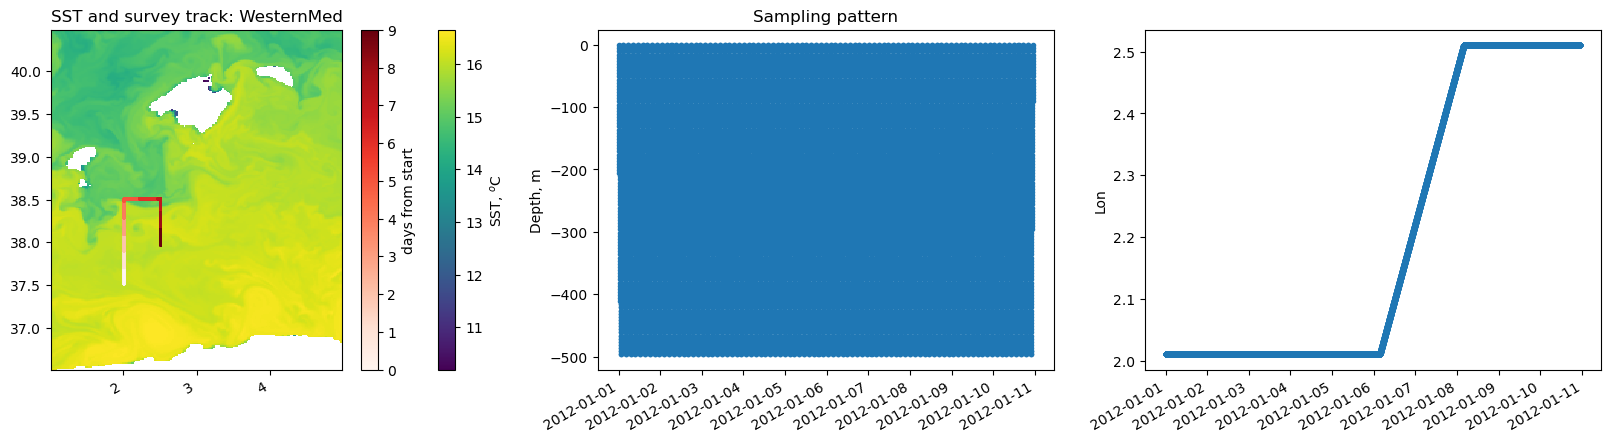

In [21]:
%matplotlib inline
plt.figure(figsize=(20,5))

# map of Theta at time zero
ax = plt.subplot(1,3,1)
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
if not (sampling_details['PLATFORM'] == 'mooring' or sampling_details['PLATFORM'] == 'sim_mooring'):
    tracko = plt.scatter(survey_track.lon, survey_track.lat, c=(survey_track.time-survey_track.time[0])/1e9/86400, cmap='Reds', s=0.75)
    plt.colorbar(ssto).set_label('SST, $^o$C')
    plt.colorbar(tracko).set_label('days from start')
    plt.title('SST and survey track: ' + RegionName)
else:
    plt.plot(survey_track.lon, survey_track.lat, marker='*', c='r')
    plt.title('SST and mooring location: ' + RegionName + ' region')


# depth/time plot of first few datapoints
ax = plt.subplot(1,3,2)
iplot = slice(0,20000)
if not (sampling_details['PLATFORM'] == 'mooring'):
    plt.plot(survey_track.time.isel(points=iplot), survey_track.dep.isel(points=iplot), marker='.')
else:
    # not quite right but good enough for now.
    # (times shouldn't increase with depth)
    plt.scatter((np.tile(survey_track['time'].isel(time=iplot), int(survey_track['dep'].data.size))),
         np.tile(survey_track['dep'], int(survey_track['time'].isel(time=iplot).data.size)),marker='.')             
# plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])
plt.ylabel('Depth, m')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('Sampling pattern')

# lon/time plot
ax = plt.subplot(1,3,3)
iplot = slice(0,20000)
if not (sampling_details['PLATFORM'] == 'mooring'):
    plt.plot(survey_track.time.isel(points=iplot), survey_track.lon.isel(points=iplot), marker='.')
else:
    # not quite right but good enough for now.
    # (times shouldn't increase with depth)
    plt.scatter((np.tile(survey_track['time'].isel(time=iplot), int(survey_track['lon'].data.size))),
         np.tile(survey_track['lon'], int(survey_track['time'].isel(time=iplot).data.size)),marker='.')             
# plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])
plt.ylabel('Lon')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()



# save
if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_sampling.png', dpi=400, transparent=False, facecolor='white')

plt.show()

### MAIN FUNCTION OF OCEANLINER:
Interpolate data with the specified sampling PATTERN to create `subsampled_data` then put on a regular grid and store in `sgridded`

In [22]:
%%time

# xarray raises a future version / depracation warning...
warnings.filterwarnings(action='ignore', category=FutureWarning)

subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices, sampling_details)
sgridded

Interpolating model fields to the sampling track...
Gridding the interpolated data...
  Theta
  Salt
  U
  V
CPU times: user 1min 5s, sys: 5.47 s, total: 1min 10s
Wall time: 1min


<xarray.Dataset>
Dimensions:   (depth: 100, time: 172)
Coordinates:
  * depth     (depth) float64 -1.0 -6.0 -11.0 -16.0 ... -486.0 -491.0 -496.0
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-10T21:29:10
Data variables: (12/15)
    Theta     (depth, time) float64 16.07 16.08 16.08 ... 13.23 13.24 13.24
    Salt      (depth, time) float64 37.1 37.12 37.12 37.12 ... 38.37 38.37 38.37
    U         (depth, time) float64 0.1182 0.08379 0.08343 ... -0.04389 -0.04387
    V         (depth, time) float64 0.02124 -0.026 ... -0.01678 -0.01676
    Eta       (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    KPPhbl    (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    ...        ...
    oceFWflx  (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceQnet   (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceQsw    (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceSflux  (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    lon       (time) float64 2.01 2.01 2.01 2.01 2.01 ... 2.51 2.51 2.51 2.51
    lat       (time) float64 37.51 37.52 37.53 37.54 ... 38.01 38.0 37.99 37.98

### Visualizations

Basic plots to show the interpolated variables

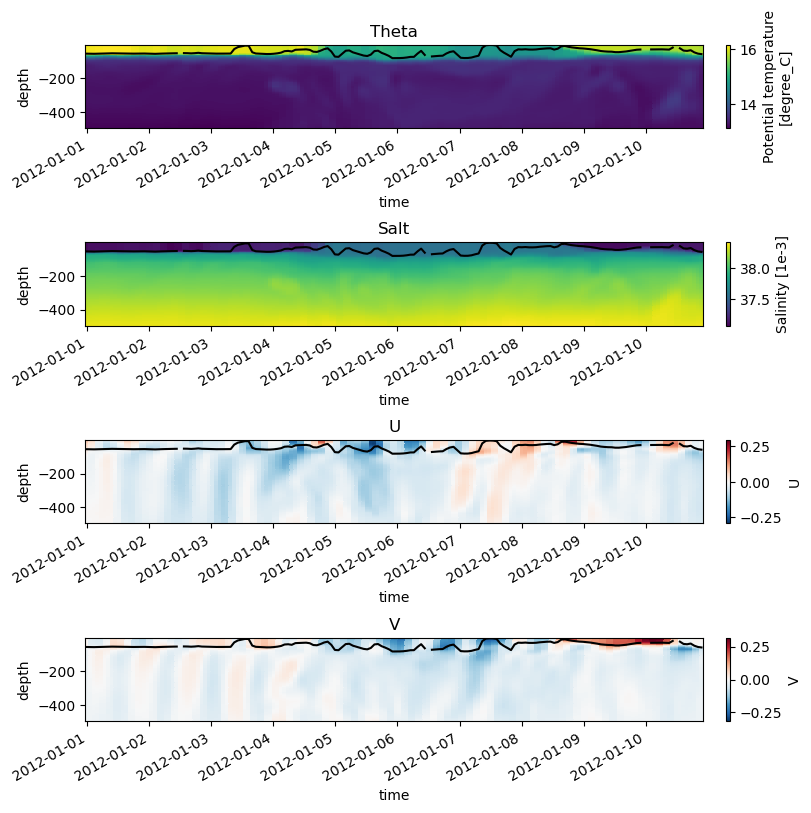

In [23]:
# 3d fields
vbls3d = ['Theta','Salt', 'U', 'V']       
if ((sampling_details['DERIVED_VARIABLES']) and ('vorticity' in sampling_details['DERIVED_VARIABLES'])):
    vbls3d.append('vorticity')
  
    

ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
# ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')


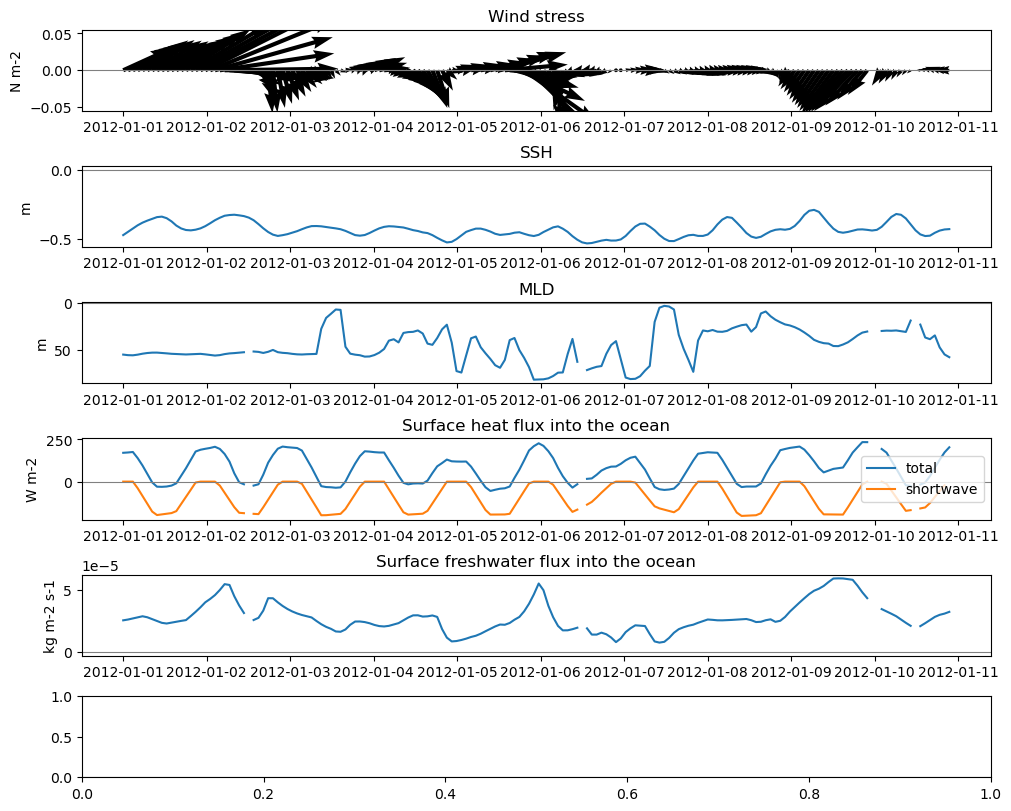

In [24]:
## selected 2d fields
j=0
nr = 6 # # of rows
fig,ax=plt.subplots(nr,figsize=(10,8),constrained_layout=True)


# wind vectors
ax[j].quiver(sgridded.time.data,0,sgridded.oceTAUX.data, sgridded.oceTAUY.data)
ax[j].set_title('Wind stress')    
ax[j].set_ylabel('N m-2')
# SH 
if ((sampling_details['DERIVED_VARIABLES']) and ('steric_height' in sampling_details['DERIVED_VARIABLES'])):
    j+=1
    ax[j].plot(sgridded.time,sgridded.steric_height-sgridded.steric_height.mean(), 
                 sgridded.time.data,sgridded.steric_height_true-sgridded.steric_height_true.mean())
    ax[j].set_title('Steric height')
    ax[j].legend(['subsampled','true'])
    ax[j].set_ylabel('m')

# SSH
j+=1
ax[j].plot(sgridded.time,sgridded.Eta)
ax[j].set_title('SSH')
ax[j].set_ylabel('m')

# MLD
j+=1
ax[j].plot(sgridded.time,sgridded.KPPhbl)
ax[j].set_title('MLD')
ax[j].set_ylabel('m')
ax[j].invert_yaxis()

# surface heat flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceQnet, sgridded.time,sgridded.oceQsw)
ax[j].set_title('Surface heat flux into the ocean')
ax[j].legend(['total','shortwave'])
ax[j].set_ylabel('W m-2')

# surface FW flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceFWflx)
ax[j].set_title('Surface freshwater flux into the ocean') 
ax[j].set_ylabel('kg m-2 s-1')

# horiz line:
for j in range(nr):
    ax[j].axhline(0, color='grey', linewidth=0.8)

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_2D.png', dpi=400, transparent=False, facecolor='white')
   

## Computing vorticity: 1 day

In [36]:
target_files[0]

'/home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120101.nc'

In [39]:
#ds1 = target_files[0]
ds1 = xr.open_mfdataset(target_files[0])

In [40]:
# mean lat/lon of domain
xav = ds1.XC.isel(j=0).mean(dim='i')
yav = ds1.YC.isel(i=0).mean(dim='j')


# for transforming U and V, and for the vorticity calculation, build the xgcm grid:
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                            'Y':{'center': 'j', 'left': 'j_g'},
                            'T':{'center': 'time'},
                            'Z':{'center': 'k'}})


In [42]:
vorticity = (grid.diff(ds1.V*ds1.DXG, 'X') - grid.diff(ds1.U*ds1.DYG, 'Y'))/ds1.RAZ
vorticity = grid.interp(grid.interp(vorticity, 'X', boundary='extend'), 'Y', boundary='extend')

In [45]:
np.shape(vorticity)

(24, 76, 265, 192)

In [46]:
vorticity

<xarray.DataArray 'mul-8fb4da0e227980c1069833ccb9d57641' (time: 24, k: 76,
                                                          j: 265, i: 192)>
dask.array<mul, shape=(24, 76, 265, 192), dtype=float64, chunksize=(24, 76, 263, 190), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 ... 2012-01-01T23:00:00
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 66 67 68 69 70 71 72 73 74 75
  * j        (j) float32 0.0 1.0 2.0 3.0 4.0 ... 260.0 261.0 262.0 263.0 264.0
  * i        (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0

In [50]:
from datetime import timedelta

In [54]:
def compute_derived_fields(RegionName, datadir, start_date, ndays, DERIVED_VARIABLES):
    """ Check for derived files in {datadir}/derived and compute if the files don't exist


    Args:
        RegionName (str): It can be selected from the list of regions with pre-SWOT llc4320 data
        datadir (str): Directory where input model files are stored
        start_date (datetime): Starting date for computing derived fields
        ndays (int): Number of days from the start date to compute derived fields
        DERIVED_VARIABLES (str list): specifies which variables to derive (steric_height and/or vorticity)

    Returns:
        None
        
    Raises: 
        TBD: TBD

    """
    
    # directory to save derived data to - create if doesn't exist
    derivedir = datadir + 'derived/'
    if not(os.path.isdir(derivedir)):
        os.mkdir(derivedir)
        
    # files to load:
    date_list = [start_date + timedelta(days=x) for x in range(ndays)]
    target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    
    # list of derived files:
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files

        
    # loop through input files, then do the following:
    # - compute steric height
    # - interpolate vector quantities (velocity and wind) to the tracer grid
    # - compute vorticity
    fis = range(len(target_files))
    
    cnt = 0 # count
    for fi in fis:
        # input filename:
        thisf=target_files[fi]
        # output filename:
        fnout = thisf.replace(RegionName + '_' , RegionName + '_derived-fields_')
        fnout = fnout.replace(RegionName + '/' , RegionName + '/derived/')
        # check if output file already exists
        if (not(os.path.isfile(fnout))):   
            print(f'computing {DERIVED_VARIABLES} for {thisf}') 
            # load file:
            ds = xr.open_dataset(thisf)
            
            if 'steric_height' in DERIVED_VARIABLES:
                # -------
                # first time through the loop, load reference profile:
                # load a single file to get coordinates
                if cnt==0:
                    # mean lat/lon of domain
                    xav = ds.XC.isel(j=0).mean(dim='i')
                    yav = ds.YC.isel(i=0).mean(dim='j')

                    # for transforming U and V, and for the vorticity calculation, build the xgcm grid:
                    # see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
                    grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                                 'Y':{'center': 'j', 'left': 'j_g'},
                                 'T':{'center': 'time'},
                                 'Z':{'center': 'k'}})


                    # --- load reference file of argo data
                    # here we use the 3x3 annual mean Argo product on standard produced by IRPC & distributed by ERDDAP
                    # https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_defb_b79c_cb17.html
                    # - download the profile closest to xav,yav once (quick), use it, then delete it.

                    # URL gets temp & salt at all levels
                    argofile = f'https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_625d_3b64_cc4d.nc?temp[(0000-12-15T00:00:00Z):1:(0000-12-15T00:00:00Z)][(0.0):1:(2000.0)][({yav.data}):1:({yav.data})][({xav.data}):1:({xav.data})],salt[(0000-12-15T00:00:00Z):1:(0000-12-15T00:00:00Z)][(0.0):1:(2000.0)][({yav.data}):1:({yav.data})][({xav.data}):1:({xav.data})]'

                    # delete the argo file if it exists 
                    if os.path.isfile('argo_local.nc'):
                        os.remove('argo_local.nc')
                    # use requests to get the file, and write locally:
                    r = requests.get(argofile)
                    file = open('argo_local.nc','wb')
                    file.write(r.content)
                    file.close()
                    # open the argo file:
                    argods = xr.open_dataset('argo_local.nc',decode_times=False)
                    # get rid of time coord/dim/variable, which screws up the time in ds if it's loaded
                    argods = argods.squeeze().reset_coords(names = {'time'}, drop=True) 
                    # reference profiles: annual average Argo T/S using nearest neighbor
                    Tref = argods["temp"]
                    Sref = argods["salt"]
                    # SA and CT from gsw:
                    # see example from https://discourse.pangeo.io/t/wrapped-for-dask-teos-10-gibbs-seawater-gsw-oceanographic-toolbox/466
                    Pref = xr.apply_ufunc(sw.p_from_z, -argods.LEV, yav)
                    Pref.compute()
                    SAref = xr.apply_ufunc(sw.SA_from_SP, Sref, Pref, xav, yav,
                                           dask='parallelized', output_dtypes=[Sref.dtype])
                    SAref.compute()
                    CTref = xr.apply_ufunc(sw.CT_from_pt, Sref, Tref, # Theta is potential temperature
                                           dask='parallelized', output_dtypes=[Sref.dtype])
                    CTref.compute()
                    Dref = xr.apply_ufunc(sw.density.rho, SAref, CTref, Pref,
                                        dask='parallelized', output_dtypes=[Sref.dtype])
                    Dref.compute()


                    cnt = cnt+1
                    print()

                # -------
                # --- COMPUTE STERIC HEIGHT IN STEPS ---
                # 0. create datasets for variables of interest:
                ss = ds.Salt
                tt = ds.Theta
                pp = xr.DataArray(sw.p_from_z(ds.Z,ds.YC))

                # 1. compute absolute salinity and conservative temperature
                sa = xr.apply_ufunc(sw.SA_from_SP, ss, pp, xav, yav, dask='parallelized', output_dtypes=[ss.dtype])
                sa.compute()
                ct = xr.apply_ufunc(sw.CT_from_pt, sa, tt, dask='parallelized', output_dtypes=[ss.dtype])
                ct.compute()
                dd = xr.apply_ufunc(sw.density.rho, sa, ct, pp, dask='parallelized', output_dtypes=[ss.dtype])
                dd.compute()
                # 2. compute specific volume anomaly: gsw.density.specvol_anom_standard(SA, CT, p)
                sva = xr.apply_ufunc(sw.density.specvol_anom_standard, sa, ct, pp, dask='parallelized', output_dtypes=[ss.dtype])
                sva.compute()
                # 3. compute steric height = integral(0:z1) of Dref(z)*sva(z)*dz(z)
                # - first, interpolate Dref to the model pressure levels
                Drefi = Dref.interp(LEV=-ds.Z)
                dz = -ds.Z_bnds.diff(dim='nb').drop_vars('nb').squeeze() # distance between interfaces

                # steric height computation (summation/integral)
                # - increase the size of Drefi and dz to match the size of sva
                Db = Drefi.broadcast_like(sva)
                dzb = dz.broadcast_like(sva)
                dum = Db * sva * dzb
                sh = dum.cumsum(dim='k') 
                # this gives sh as a 3-d variable, (where the depth dimension 
                # represents the deepest level from which the specific volume anomaly was interpolated)
                # - but in reality we just want the SH that was determined by integrating over
                # the full survey depth, which gives a 2-d output:
                sh_true = dum.sum(dim='k') 
            
                # make into dataset:
                sh_ds = sh.to_dataset(name='steric_height')
                sh_true_ds = sh_true.to_dataset(name='steric_height_true')            
                # add/rename the Argo reference profile variables to dout:
                tref = Tref.to_dataset(name='Tref')
                tref = tref.merge(Sref).rename({'salt': 'Sref'}).\
                    rename({'LEV':'zref','latitude':'yav','longitude':'xav'})
            
            if 'vorticity' in DERIVED_VARIABLES:   
                # mean lat/lon of domain
                xav = ds.XC.isel(j=0).mean(dim='i')
                yav = ds.YC.isel(i=0).mean(dim='j')

                # for transforming U and V, and for the vorticity calculation, build the xgcm grid:
                # see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
                grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                                 'Y':{'center': 'j', 'left': 'j_g'},
                                 'T':{'center': 'time'},
                                 'Z':{'center': 'k'}})
                # --- COMPUTE VORTICITY using xgcm and interpolate to X, Y
                # see https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html
                vorticity = (grid.diff(ds.V*ds.DXG, 'X') - grid.diff(ds.U*ds.DYG, 'Y'))/ds.RAZ
                vorticity = grid.interp(grid.interp(vorticity, 'X', boundary='extend'), 'Y', boundary='extend')
                # make into dataset
                v_ds =vorticity.to_dataset(name='vorticity')
     
    
    
            
            # --- save derived fields in a new file
            if 'steric_height' in DERIVED_VARIABLES:
                dout = sh_ds
                dout = dout.merge(sh_true_ds)
                # - add ref profiles to dout and drop uneeded vars/coords
                dout = dout.merge(tref).drop_vars({'longitude','latitude','LEV'})
                # - add attributes for all variables
                dout.steric_height.attrs = {'long_name' : 'Steric height',
                                        'units' : 'm',
                                        'comments_1' : 'Computed by integrating the specific volume anomaly (SVA) multiplied by a reference density, where the reference density profile is calculated from temperature & salinity profiles from the APDRC 3x3deg gridded Argo climatology product (accessed through ERDDAP). The profile nearest to the center of the domain is selected, and T & S profiles are averaged over one year before computing ref density. SVA is computed from the model T & S profiles. the Gibbs Seawater Toolbox is used compute reference density and SVA. steric_height is given at all depth levels (dep): steric_height at a given depth represents steric height signal generated by the water column above that depth - so the deepest steric_height value represents total steric height (and is saved in steric_height_true'
                                           }
                dout.steric_height_true.attrs = dout.steric_height.attrs
                dout.Tref.attrs = {'long_name' : f'Reference temperature profile at {yav.data}N,{xav.data}E',
                                    'units' : 'degree_C',
                                    'comments_1' : 'From Argo 3x3 climatology produced by APDRC'}
                dout.Sref.attrs = {'long_name' : f'Reference salinity profile at {yav.data}N,{xav.data}E',
                                        'units' : 'psu',
                                        'comments_1' : 'From Argo 3x3 climatology produced by APDRC'}

                dout.zref.attrs = {'long_name' : f'Reference depth for Tref and Sref',
                                        'units' : 'm',
                                        'comments_1' : 'From Argo 3x3 climatology produced by APDRC'}
                
                # merge vorticity 
                if 'vorticity' in DERIVED_VARIABLES:  
                    dout = dout.merge(v_ds)
                    
            # if we only computed vorticity, dout = v_ds
            elif 'vorticity' in DERIVED_VARIABLES:  
                dout = v_ds
                
                
            # if vorticity, add the attrs:
            if 'vorticity' in DERIVED_VARIABLES:  
                dout.vorticity.attrs = {'long_name' : 'Vertical component of the vorticity',
                                    'units' : 's-1',
                                    'comments_1' : 'computed on DXG,DYG then interpolated to X,Y'}         
               
            # - save netcdf file with derived fields
            netcdf_fill_value = nc4.default_fillvals['f4']
            dv_encoding = {}
            for dv in dout.data_vars:
                dv_encoding[dv]={'zlib':True,  # turns compression on\
                            'complevel':1,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                            'dtype':'float32',\
                            '_FillValue':netcdf_fill_value}
            # save to a new file
            print(' ... saving to ', fnout)
            # TROUBLESHOOTING::::: DELETE THE RETURN LINE
            #return dout, dv_encoding
            dout.to_netcdf(fnout,format='netcdf4',encoding=dv_encoding)

            
            
    # release Argo file at the end of all files
    if 'argods' in locals():
        argods.close()

In [55]:
DERIVED_VARIABLES = {'vorticity'}

In [56]:
compute_derived_fields(RegionName, datadir, start_date, ndays, DERIVED_VARIABLES)

computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120101.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived-fields_20120101.nc
computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120102.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived-fields_20120102.nc
computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120103.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived-fields_20120103.nc
computing {'vorticity'} for /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_20120104.nc
 ... saving to  /home/manjaree/Documents/oceanliner_data/osse_model_input/LLC4320_pre-SWOT_WesternMed_derived

In [58]:
sampling_details['DERIVED_VARIABLES'] = {'vorticity'}

<xarray.Dataset>
Dimensions:   (depth: 100, time: 172)
Coordinates:
  * depth     (depth) float64 -1.0 -6.0 -11.0 -16.0 ... -486.0 -491.0 -496.0
  * time      (time) datetime64[ns] 2012-01-01 ... 2012-01-10T21:29:10
Data variables: (12/15)
    Theta     (depth, time) float64 16.07 16.08 16.08 ... 13.23 13.24 13.24
    Salt      (depth, time) float64 37.1 37.12 37.12 37.12 ... 38.37 38.37 38.37
    U         (depth, time) float64 0.1182 0.08379 0.08343 ... -0.04389 -0.04387
    V         (depth, time) float64 0.02124 -0.026 ... -0.01678 -0.01676
    Eta       (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    KPPhbl    (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    ...        ...
    oceFWflx  (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceQnet   (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceQsw    (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    oceSflux  (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    lon       (time) float64 2.01 2.01 2.01 2.01 2.01 ... 2.51 2.51 2.51 2.51
    lat       (time) float64 37.51 37.52 37.53 37.54 ... 38.01 38.0 37.99 37.98

KeyError: 'vorticity'

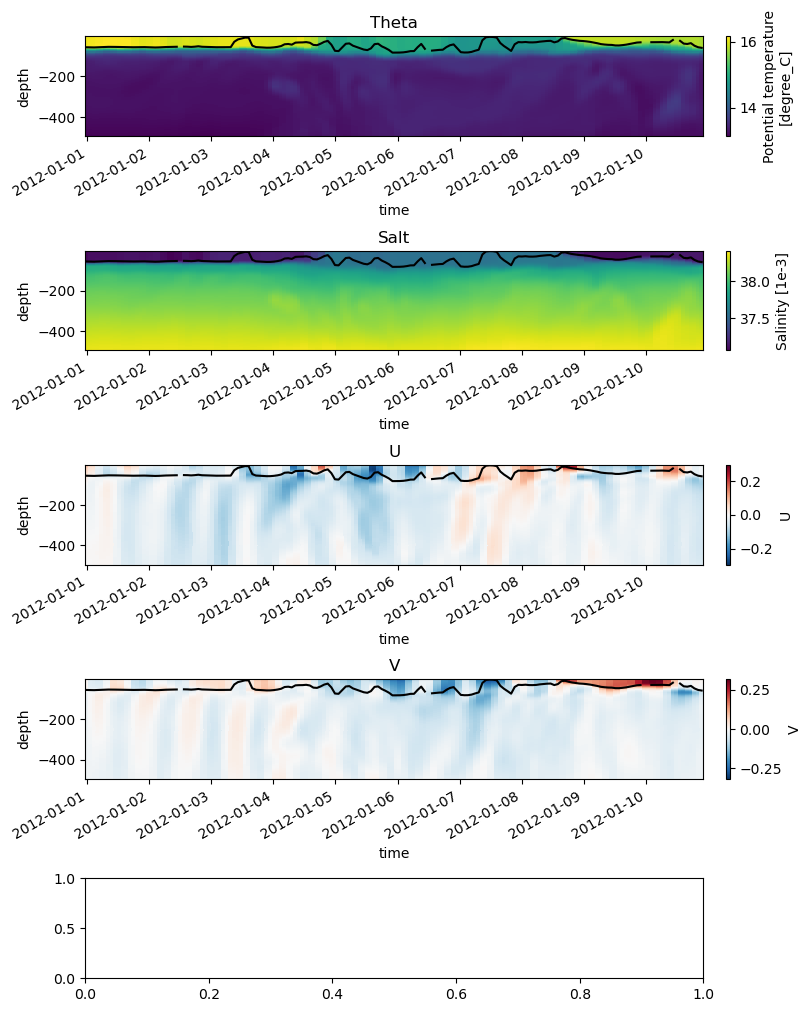

In [59]:
# 3d fields
vbls3d = ['Theta','Salt', 'U', 'V']       
if ((sampling_details['DERIVED_VARIABLES']) and ('vorticity' in sampling_details['DERIVED_VARIABLES'])):
    vbls3d.append('vorticity')
  
    

ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
# ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')


### Save interpolated data

For both raw and gridded subsampled data, add attributes and save


In [ ]:
# add metadata to attributes
attrs = sampling_details
attrs['start_date'] = start_date.strftime('%Y-%m-%d')
end_date = sgridded['time'].data[-1]
attrs['end_date'] = np.datetime_as_string(end_date,unit='D')
attrs['ndays'] = ndays
attrs.pop('DERIVED_VARIABLES')

In [ ]:
# ------ subsampled data
# this is slow and generates a huge file, so consider skipping
if sampling_parameters['PLATFORM'] != 'mooring':
    filename_out = filename_out_base + '_subsampled.nc'
    print(f'saving to {filename_out}')
    subsampled_data.attrs = attrs
    netcdf_fill_value = nc4.default_fillvals['f4']
    dv_encoding={'zlib':True,  # turns compression on\
                'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                'dtype':'float32',\
                '_FillValue':netcdf_fill_value}
    # save to a new file
    # subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
    subsampled_data.to_netcdf(filename_out,format='netcdf4')
    !ls -ltrh {filename_out}

In [ ]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}

In [ ]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}


### Visualize interpolated data in 3D

In [ ]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(subsampled_data.lon.data, subsampled_data.lat.data, subsampled_data.dep.data, c=subsampled_data.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')